# **Topic Modelling**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [4]:
clients = pd.read_excel('btUTgX.xlsx', index_col=0)
complaints = pd.read_excel('EaUgXb.xlsx', index_col = 0)

In [5]:
complaints.head()

,complaint,complaint_number
customerID,,
9565-DJPIB,The streaming TV service frequently buffers or...,1
4342-HFXWS,The DSL internet service has been inconsistent...,1
4342-HFXWS,The streaming TV service often buffers excessi...,2
4342-HFXWS,"Despite having tech support included, it takes...",3
4342-HFXWS,The device protection plan I pay for did not c...,4


In [6]:
data = complaints.drop(columns=['complaint_number'])

Modelli da provare:
- gensim 
- scikit learn
- **BERTopic**
- **Doc2Vec**
- Mallet (via Gensim)
- Octis


## **Gensim**
Useful notebooks: 
https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Introduction%20to%20Topic%20Modeling.ipynb this is the one I am using 


https://github.com/storopoli/topic-modelling/blob/master/Notebooks/gensim-topics.ipynb

In [7]:
import os
import sys
import gensim

from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

print('Python Version: %s' % (sys.version))

Python Version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 13:04:33) [Clang 14.0.6 ]


In [ ]:
# ----- DATA CLEANING -----
import re

# Remove punctuation
data['text_processed'] = \
data['complaint'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
data['text_processed'] = \
data['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
data['text_processed'].head()

customerID
9565-DJPIB    the streaming tv service frequently buffers or...
4342-HFXWS    the dsl internet service has been inconsistent...
4342-HFXWS    the streaming tv service often buffers excessi...
4342-HFXWS    despite having tech support included it takes ...
4342-HFXWS    the device protection plan i pay for did not c...
Name: text_processed, dtype: object

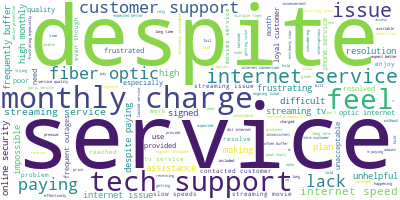

In [11]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(data['text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

Plot mega trash ma divertente.

Now we transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [ ]:
# ----- PREPARE TEXT -----
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = data.text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatricecitterio/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['streaming', 'tv', 'service', 'frequently', 'buffers', 'crashes', 'making', 'impossible', 'watch', 'anything', 'without', 'interruptions', 'ongoing', 'despite', 'high', 'monthly', 'charges', 'frustrated', 'lack', 'reliability']


In [13]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


In [20]:
# ------ LDA MODEL ------
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"monthly" + 0.027*"services" + 0.026*"charges" + 0.026*"high" + '
  '0.022*"streaming" + 0.021*"like" + 0.020*"service" + 0.020*"feel" + '
  '0.017*"paying" + 0.016*"despite"'),
 (1,
  '0.041*"service" + 0.024*"internet" + 0.019*"despite" + 0.015*"making" + '
  '0.011*"frequent" + 0.011*"streaming" + 0.011*"phone" + 0.011*"like" + '
  '0.009*"frustrating" + 0.009*"issue"'),
 (2,
  '0.041*"support" + 0.032*"service" + 0.030*"customer" + 0.029*"internet" + '
  '0.023*"issues" + 0.018*"streaming" + 0.015*"like" + 0.015*"tech" + '
  '0.015*"issue" + 0.013*"resolution"'),
 (3,
  '0.041*"service" + 0.034*"internet" + 0.023*"despite" + 0.022*"streaming" + '
  '0.019*"fiber" + 0.019*"optic" + 0.017*"paying" + 0.017*"frustrating" + '
  '0.016*"services" + 0.015*"support"'),
 (4,
  '0.040*"internet" + 0.037*"service" + 0.021*"paying" + 0.019*"despite" + '
  '0.015*"support" + 0.014*"online" + 0.014*"customer" + 0.014*"slow" + '
  '0.013*"speed" + 0.013*"consistently"')]


In the above, parameters are set to default except for number of topics. We will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.


**Visualization** - let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:
1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.


For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [21]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.002628 -0.018224       1        1  30.523614
2     -0.013958  0.064935       2        1  24.892617
0     -0.078227 -0.037424       3        1  24.741431
4      0.025611  0.032724       4        1  11.675032
1      0.069201 -0.042011       5        1   8.167305, topic_info=           Term        Freq       Total Category  logprob  loglift
15      service  807.000000  807.000000  Default  30.0000  30.0000
27     internet  671.000000  671.000000  Default  29.0000  29.0000
108       speed  148.000000  148.000000  Default  28.0000  28.0000
77         slow  177.000000  177.000000  Default  27.0000  27.0000
47      support  490.000000  490.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
16    streaming   21.573785  457.673521   Topic5  -4.5212  -0.5496
226   extremely   15.488953  160.937536   Topic5  -4.8525   0.1641
106      paying   17.465239  341.782125   Topic5  -4.7325  -0.4689
17           tv   14.919827  240.900702   Topic5  -4.8900  -0.2767
91   especially   13.652829  187.348455   Topic5  -4.9787  -0.1140

[397 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
151       1  0.763644  ability
151       2  0.109092  ability
151       3  0.036364  ability
151       5  0.072728  ability
298       2  0.277601   action
...     ...       ...      ...
287       2  0.313477    would
287       3  0.330422    would
287       4  0.059307    would
287       5  0.059307    would
460       4  0.533182    wrong

[861 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

## **BERTopic**

In [33]:
complaints = pd.read_excel('EaUgXb.xlsx', index_col = 0)

In [34]:
data = complaints['complaint'].values.tolist()


In [ ]:
import plotly.io as pio
pio.renderers.default = "browser"

from bertopic import BERTopic

topic_model = BERTopic()
topics, probabilities = topic_model.fit_transform(data)



topics is a list of topic numbers assigned to each doc; probabilities is how confident the model is for each assignment.

In [44]:
# See all topics
print(topic_model.get_topic_info())

# See the words describing a specific topic
print(topic_model.get_topic(0))  # 0 is the topic id

    Topic  Count                                       Name  \
0      -1    105                           -1_the_to_and_my   
1       0    298           0_streaming_tv_movies_frequently   
2       1    104             1_tech_support_assistance_when   
3       2     96               2_feel_monthly_getting_value   
4       3     86           3_support_streaming_about_issues   
5       4     74               4_optic_fiber_speed_internet   
6       5     71            5_issues_customer_support_about   
7       6     63          6_unreliable_outages_frequent_has   
8       7     63                    7_phone_calls_call_poor   
9       8     62             8_dsl_speed_difficult_complete   
10      9     57             9_optic_fiber_outages_frequent   
11     10     49  10_charges_explanation_breakdown_detailed   
12     11     49                 11_security_online_of_lack   
13     12     47       12_loyalty_discounts_loyal_customers   
14     13     45         13_options_available_internet_

In [37]:
topic_model.visualize_topics()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
# How topics change across documents
topic_model.visualize_barchart()

# How words are represented in topics
topic_model.visualize_term_rank()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
topic_model = topic_model.reduce_topics(data, nr_topics=10)
topic_model.visualize_topics()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
topic_model.visualize_hierarchy()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [46]:
for i in range(10):
    print(f'Topic {i+1}')
    print(topic_model.get_topic(i))


Topic 1
[('the', 0.05949849543076489), ('and', 0.05232449761267515), ('has', 0.050298376009025716), ('streaming', 0.050218540944716054), ('been', 0.04870633033292908), ('it', 0.043332557691124325), ('service', 0.04264845539765703), ('internet', 0.042450420264715565), ('to', 0.04199130541570957), ('for', 0.03838324704639602)]
Topic 2
[('support', 0.0963175961417815), ('issues', 0.06720364642362879), ('customer', 0.06260070368447718), ('to', 0.059569975996554426), ('tech', 0.057578965926892274), ('assistance', 0.05430206384487431), ('but', 0.05277435735329483), ('was', 0.0506030732699343), ('the', 0.04799756478631043), ('when', 0.046592628366735986)]
Topic 3
[('monthly', 0.08962083650944319), ('charges', 0.08885398340583345), ('the', 0.07758655050270674), ('like', 0.07737881656728497), ('high', 0.07341345800267873), ('for', 0.06712994799979906), ('feel', 0.06531961906395294), ('services', 0.05451715928946297), ('value', 0.050020292023994), ('are', 0.04966637935494818)]
Topic 4
[('securit

In [47]:
# better embedding
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
topic_model = BERTopic(embedding_model=embedding_model)
topics, probs = topic_model.fit_transform(data)

In [ ]:
for i in range(10):
    print(f'Topic {i+1}')
    print(topic_model.get_topic(i))

In [58]:
# try cleaning data first
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(d):
    tokens = d.lower().split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

cleaned_data = [clean_text(d) for d in data]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatricecitterio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
topic_model = BERTopic(embedding_model=embedding_model, nr_topics=10)
topics, probs = topic_model.fit_transform(cleaned_data)

In [60]:
for i in range(10):
    print(f'Topic {i+1}')
    print(topic_model.get_topic(i))

Topic 1
[('streaming', 0.06025800873339166), ('service', 0.058226820929994066), ('internet', 0.057323203066296305), ('movies', 0.052145615907395235), ('tv', 0.052129077877479675), ('making', 0.04891476027994632), ('optic', 0.04748763958348591), ('fiber', 0.04748763958348591), ('paying', 0.04563527624700714), ('despite', 0.04419652561110941)]
Topic 2
[('support', 0.138134668416225), ('issues', 0.09623888796745121), ('customer', 0.09247659213546132), ('tech', 0.07663926430044705), ('assistance', 0.07656094233113538), ('contacted', 0.06112999762933804), ('resolution', 0.056039099468821914), ('unhelpful', 0.055859937263463014), ('get', 0.0516461723952984), ('internet', 0.051639017789083565)]
Topic 3
[('monthly', 0.12231790293131192), ('charges', 0.12096874052599572), ('like', 0.10756266923379672), ('high', 0.09960197848814177), ('feel', 0.08966113324618984), ('value', 0.07322148900083278), ('services', 0.07204598483772147), ('getting', 0.06901179090130684), ('receiving', 0.0568192788549999

In [61]:
topic_model.visualize_topics()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# How topics change across documents
topic_model.visualize_barchart()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
